In [1]:
import sys
import pandas as pd
import numpy as np
import os
import io
import matplotlib.pyplot as plt
import matplotlib.colors
import json
from urllib.request import urlopen
import dash
import plotly_express as px
import plotly.graph_objects as go
import nbformat
import json
import urllib
import seaborn as sns
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.neighbors import KNeighborsClassifier as KNNc
import sklearn.metrics as Metrics
import re 
from shapely.geometry import Point
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
ny = pd.read_csv("/Users/fondairenasantoso/airbnb_data_analysis/cleaned_airbnb_listings.csv")
cal= pd.read_csv("/Users/fondairenasantoso/airbnb_data_analysis/data/calendar.csv")
rev= pd.read_csv("/Users/fondairenasantoso/airbnb_data_analysis/data/reviews1.csv")

### Set Visualization Styles

In [3]:
#COLOR LIRABRY

AIR_GREEN = '#808000'
AIR_VIOLET = '#EE82EE'
AIR_ORANGE=  '#FF4500'
AIR_BLUE = '0000FF'

#setting the size for visualizations

sns.set(rc={'figure.figsize':(10,8)},font='sans-serif',font_scale=1,color_codes=True)

### Explore Prices

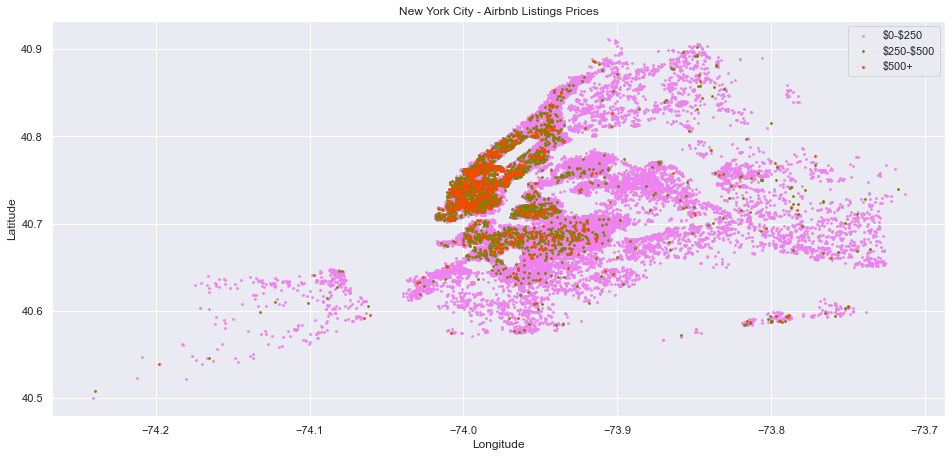

In [4]:
#divide prices in ny_3 into several categories

#price bucket intervals
intervals = [0,250,500,1000]
category = []
colors = [AIR_VIOLET, AIR_GREEN, AIR_ORANGE]
  
for i in range(0, len(intervals) -1):
    category.append(ny[(ny['price'] > intervals[i]) & (ny['price'] < intervals[i+1])])

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(212)
    
for i in range(0, len(category)):
    ax.scatter(category[i]['longitude'],category[i]['latitude'], s=3, c=colors[i])

#Add Legends 

labels = []

for i in range(0,len(intervals) - 1):
    if i == len(intervals)-2:
        labels.append('\${}+'.format(intervals[i]))
    else:
        labels.append("\${}-\${}".format(intervals[i], intervals[i+1]))
        
#Add Titles
ax.set_title('New York City - Airbnb Listings Prices')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(labels=labels)


In [5]:
#turn 'available' into numericals

cal.loc[cal.loc[:, 'available']=='t','available']=1
cal.loc[cal.loc[:, 'available']=='f','available']=0

In [6]:
#replace NaN values with 0 
cal.fillna(0,inplace=True)
cal = cal[cal.price != 0]

In [7]:
#convert price into float
prices = ['price']
for x in prices:
    cal[x]=cal[x].str.replace('$','').str.replace(',','')
    cal[x]=cal[x].astype(float)
    
#turn 'date' into datetime 

cal['date'] = pd.to_datetime(cal['date'])

#plot listings availability
grouped_cal = cal.groupby('date')['available'].sum()
grouped_cal.iplot(kind='scatter', title = 'Listings Availability')

In [8]:
grouped_cal2 = cal.groupby('date')['price'].sum()
grouped_cal2.iplot(kind='scatter', title = 'Listing Prices')




In [9]:
ny['cancellation_policy'].unique()

array(['flexible', 'strict_14_with_grace_period', 'moderate',
       'super_strict_60', 'strict', 'super_strict_30'], dtype=object)

Text(0.5, 8.91312499999998, 'Overview of Cancellation Policy and Price ')

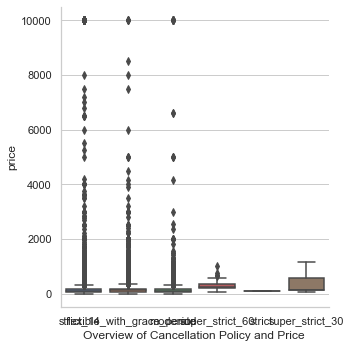

In [10]:
#see correlations between price and cancellation policy

sns.set(rc={'figure.figsize':(20,10)},style='whitegrid')
fig4= sns.catplot(x='cancellation_policy',y='price',data=ny,kind='box')
plt.xlabel('Overview of Cancellation Policy and Price ')

In [11]:
#Calculate average prices for each type of property type 

avg_price_property = ny.groupby('property_type').price.mean()
avg_price_property = avg_price_property.reset_index()
avg_price_property = avg_price_property.rename(columns= {'price':'average price'})


In [12]:
#plot the chart of avg_price_property 

fig3 = px.bar(avg_price_property, x='property_type',y='average price',color ='average price',color_continuous_scale='Tealgrn')
fig3.show()

In [13]:
#grouping neighbourhood by # of listings 

neigh_listings = ny.groupby('neighbourhood_cleansed').id.count()
neigh_listings = neigh_listings.reset_index()
neigh_listings = neigh_listings.rename(columns={'id':'Number of Listings'})
neigh_listings = neigh_listings.sort_values(['Number of Listings'])

#Plot average prices for each neighbourhood

neigh_avg_price = ny.groupby('neighbourhood_cleansed').price.mean()
merged = pd.merge(neigh_avg_price, neigh_listings, on='neighbourhood_cleansed')
merged = merged.rename(columns={'price':'average price'})

fig2 = px.bar(merged, x='neighbourhood_cleansed',y='Number of Listings',color ='average price',color_continuous_scale='Tealgrn')
fig2.show()

In [14]:
merged.sort_values(by=['average price'], ascending=False)

neighbourhood_cleansed  average price  Number of Listings
220                Woodrow    2350.000000                   2
121        Manhattan Beach     926.750000                  12
82          Fort Wadsworth     800.000000                   1
158           Prince's Bay     506.666667                   3
128                Midtown     484.124925                1673
..                     ...            ...                 ...
103            Hunts Point      53.500000                  24
89              Grant City      51.125000                   8
180              Soundview      50.882353                  17
181            South Beach      50.000000                   6
27             Bull's Head      37.666667                   3

[222 rows x 3 columns]

In [15]:
#analyze correlations between host_listings_count and price 

host_listings = ny.groupby('host_id').host_listings_count.count()
host_listings = host_listings.reset_index()
host_listings

host_id  host_listings_count
0           2259.0                    1
1           2438.0                    1
2           2571.0                    1
3           2782.0                    3
4           2787.0                    7
...            ...                  ...
37468  349059281.0                    1
37469  349062530.0                    1
37470  349076086.0                    1
37471  349078564.0                    1
37472  349082641.0                    1

[37473 rows x 2 columns]

In [16]:


host_pro = ny[['property_type','bedrooms','neighbourhood_cleansed']].merge(merged[['neighbourhood_cleansed','average price','Number of Listings']],on='neighbourhood_cleansed',how='left')

In [17]:
#plot Number of host listings and price to see the relations between them
host_avg_price = ny.groupby('host_id').price.mean()
host_avg_price = host_avg_price.reset_index()
host_merged = pd.merge(host_avg_price, host_listings, on ='host_id')
host_merged = host_merged.rename(columns={'price':'average price'})

host_merged['new_price'] = host_merged['average price'].map('{0:g}'.format)
host_merged = host_merged.rename(columns={'new_price':'average_price'})

In [18]:
host_merged['average_price'] = host_merged['average_price'].str.replace(',','')
host_merged['average_price'] = host_merged['average_price'].astype(float)

In [19]:
host_merged.sort_values(by=['host_listings_count'], ascending=False)

host_id  average price  host_listings_count  average_price
27822  107434423.0     210.085714                  280       210.0860
29484  137358866.0      46.731250                  160        46.7313
24250   61391963.0     149.482759                  116       149.4830
22247   48005494.0     160.884211                   95       160.8840
23019   51501835.0     133.488372                   86       133.4880
...            ...            ...                  ...            ...
13324   15582617.0      90.000000                    1        90.0000
13323   15581933.0      90.000000                    1        90.0000
13322   15581137.0     130.000000                    1       130.0000
13321   15579200.0     240.000000                    1       240.0000
37472  349082641.0      60.000000                    1        60.0000

[37473 rows x 4 columns]

In [20]:
px.scatter(host_merged, x="host_listings_count",y='average price')

### Explore Availability 

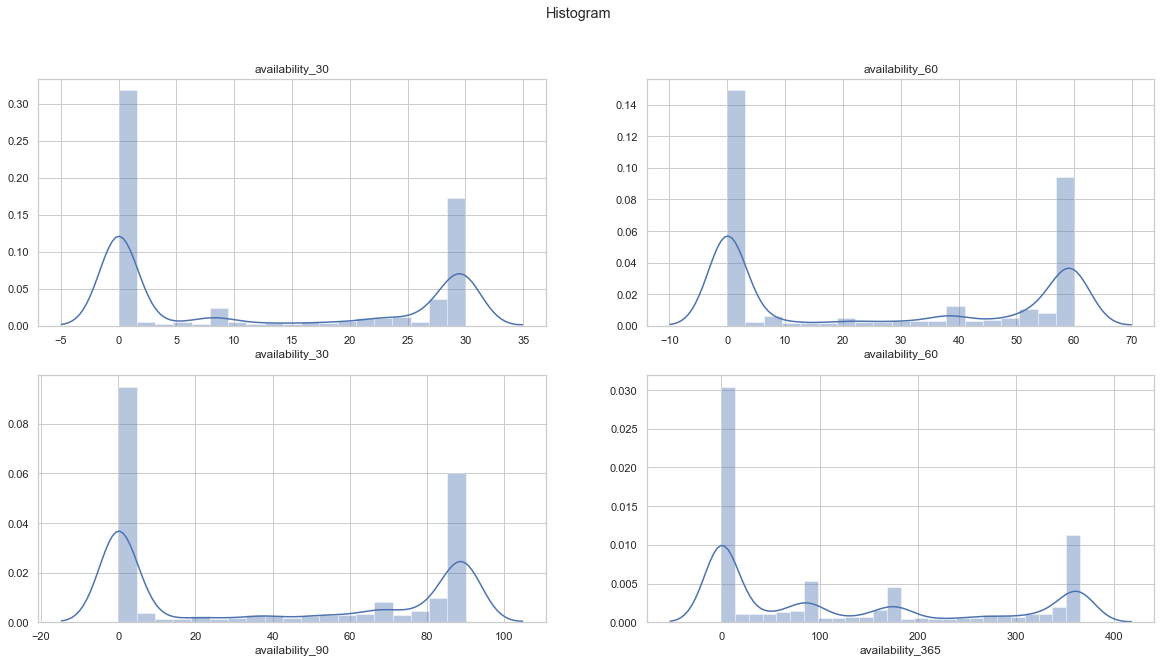

In [21]:
fig, axs = plt.subplots(ncols=2, nrows = 2)
fig.suptitle('Histogram')
sns.distplot(ny.availability_30, ax=axs[0,0]).set_title("availability_30")
sns.distplot(ny.availability_60, ax=axs[0,1]).set_title("availability_60")
sns.distplot(ny.availability_90, ax=axs[1,0])
sns.distplot(ny.availability_365, ax=axs[1,1])

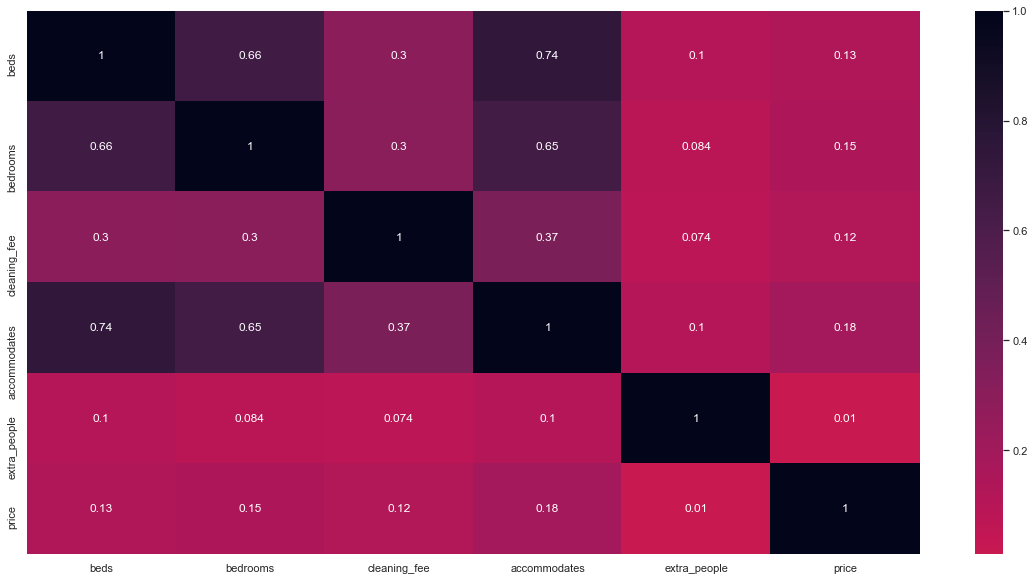

In [22]:
#show correlations amongst numeric variables
numeric = ['beds','bedrooms','cleaning_fee','accommodates','extra_people','price']
sub_df = ny[numeric]

corr = sub_df.corr()
cmap= sns.cm.rocket_r
ax = sns.heatmap(corr, annot=True, center=0, cmap=cmap, linecolor='white')

### Explore Superhosts

#### Which neighbourhood has the most superhosts?

In [23]:
neigh_host = ny.groupby(by='neighbourhood_cleansed').host_is_superhost.value_counts().sort_index()
neigh_host.fillna(value=0, inplace=True)

In [24]:
neigh_host

neighbourhood_cleansed  host_is_superhost
Allerton                f                     36
                        t                      8
Arden Heights           f                      4
                        t                      1
Arrochar                f                     14
                                            ... 
Woodlawn                f                      9
                        t                      1
Woodrow                 f                      2
Woodside                f                    302
                        t                     42
Name: host_is_superhost, Length: 428, dtype: int64

In [25]:
neighs= ny.groupby(by=['neighbourhood_cleansed','host_is_superhost'])
neighs = neighs.count()['host_listings_count'].unstack()
neighs.fillna(value=0, inplace=True)


In [28]:
neighs

host_is_superhost           f      t
neighbourhood_cleansed              
Allerton                 36.0    8.0
Arden Heights             4.0    1.0
Arrochar                 14.0    5.0
Arverne                  50.0   22.0
Astoria                 707.0  185.0
...                       ...    ...
Windsor Terrace         109.0   40.0
Woodhaven                66.0   39.0
Woodlawn                  9.0    1.0
Woodrow                   2.0    0.0
Woodside                302.0   42.0

[222 rows x 2 columns]

In [30]:
neighs['total'] = neighs.t + neighs.f

In [33]:
neighs['superhost rate'] = (neighs.t/neighs.total)*100
sorted_neighs = neighs.sort_values(by=['superhost rate'], ascending=False)
sorted_neighs.reset_index().head(20)

host_is_superhost neighbourhood_cleansed    f     t  total  superhost rate
0                           Graniteville  0.0   2.0    2.0      100.000000
1                         Fort Wadsworth  0.0   1.0    1.0      100.000000
2                               Huguenot  0.0   1.0    1.0      100.000000
3                              Rossville  0.0   1.0    1.0      100.000000
4                            Willowbrook  0.0   1.0    1.0      100.000000
5                            Eastchester  1.0  11.0   12.0       91.666667
6                           New Brighton  1.0   3.0    4.0       75.000000
7                            Westerleigh  1.0   3.0    4.0       75.000000
8                          Schuylerville  3.0   9.0   12.0       75.000000
9                           Clason Point  7.0  18.0   25.0       72.000000
10                           Castle Hill  1.0   2.0    3.0       66.666667
11                           Eltingville  1.0   2.0    3.0       66.666667
12                            Co-op City  1.0   2.0    3.0       66.666667
13                        New Dorp Beach  2.0   3.0    5.0       60.000000
14                          Dongan Hills  2.0   3.0    5.0       60.000000
15                          Belle Harbor  2.0   3.0    5.0       60.000000
16                           Bay Terrace  2.0   3.0    5.0       60.000000
17                       Manhattan Beach  5.0   7.0   12.0       58.333333
18                            Pelham Bay  7.0   9.0   16.0       56.250000
19                               Melrose  4.0   5.0    9.0       55.555556

In [34]:
#replace inf rows with NaN
neighs=neighs[neighs.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
sorted_neighs = neighs.sort_values(by=['superhost rate'], ascending=False)


In [35]:
sorted_neighs= sorted_neighs.reset_index()
sorted_neighs.head(10)

host_is_superhost neighbourhood_cleansed    f     t  total  superhost rate
0                           Graniteville  0.0   2.0    2.0      100.000000
1                         Fort Wadsworth  0.0   1.0    1.0      100.000000
2                               Huguenot  0.0   1.0    1.0      100.000000
3                              Rossville  0.0   1.0    1.0      100.000000
4                            Willowbrook  0.0   1.0    1.0      100.000000
5                            Eastchester  1.0  11.0   12.0       91.666667
6                           New Brighton  1.0   3.0    4.0       75.000000
7                            Westerleigh  1.0   3.0    4.0       75.000000
8                          Schuylerville  3.0   9.0   12.0       75.000000
9                           Clason Point  7.0  18.0   25.0       72.000000

In [37]:
# 3 of the most expensive neighbourhoods are not even in the top 10 of superhost rate. Let's see their rank in terms of superhost rate. 
high_neighs =['Midtown',"Prince's Bay",'Woodrow','Fort Wadsworth']
sorted_neighs.loc[sorted_neighs['neighbourhood_cleansed'].isin(high_neighs)]

host_is_superhost neighbourhood_cleansed       f      t   total  \
1                         Fort Wadsworth     0.0    1.0     1.0   
61                          Prince's Bay     2.0    1.0     3.0   
184                              Midtown  1453.0  220.0  1673.0   
211                              Woodrow     2.0    0.0     2.0   

host_is_superhost  superhost rate  
1                      100.000000  
61                      33.333333  
184                     13.150030  
211                      0.000000

In [38]:
#find out the property type of neighs with the highest superhost rate

sub_pro = ['property_type','neighbourhood_cleansed','longitude','latitude']
pro_host_rate = ny[['property_type','neighbourhood_cleansed','bedrooms','room_type','price','longitude','latitude']].merge(sorted_neighs[['neighbourhood_cleansed','superhost rate']],on='neighbourhood_cleansed',how='left')
pro_host_rate.sort_values(by=['superhost rate'], ascending=False).head(100)

property_type neighbourhood_cleansed  bedrooms        room_type  price  \
21823         House         Fort Wadsworth       5.0  Entire home/apt  800.0   
855           House           Graniteville       1.0     Private room   20.0   
28717         House            Willowbrook       4.0  Entire home/apt  309.0   
40682     Apartment              Rossville       1.0  Entire home/apt   69.0   
18877         House               Huguenot       1.0  Entire home/apt  180.0   
...             ...                    ...       ...              ...    ...   
44035     Apartment        Manhattan Beach       2.0  Entire home/apt   69.0   
7052          House        Manhattan Beach       1.0     Private room   45.0   
16319     Apartment        Manhattan Beach       1.0  Entire home/apt  150.0   
41186     Apartment        Manhattan Beach       2.0  Entire home/apt  150.0   
44502     Apartment        Manhattan Beach       3.0  Entire home/apt   69.0   

       longitude  latitude  superhost rate  
21823  -74.06092  40.59546      100.000000  
855    -74.16534  40.62109      100.000000  
28717  -74.13217  40.59886      100.000000  
40682  -74.20877  40.54724      100.000000  
18877  -74.16966  40.53871      100.000000  
...          ...       ...             ...  
44035  -73.95163  40.57885       58.333333  
7052   -73.93988  40.57770       58.333333  
16319  -73.95347  40.58249       58.333333  
41186  -73.95355  40.58017       58.333333  
44502  -73.95216  40.57889       58.333333  

[100 rows x 8 columns]

In [43]:
#show only rows with superhost rate more than 30%
above_30 = pro_host_rate['superhost rate']>30

In [47]:
up_30 = pro_host_rate[above_30]
up_30.head()

property_type neighbourhood_cleansed  bedrooms        room_type  price  \
11      Townhouse            South Slope       1.0     Private room   89.0   
26      Townhouse            South Slope       1.0     Private room   89.0   
49          House               Red Hook       1.0     Private room   89.0   
97      Apartment            South Slope       1.0  Entire home/apt   90.0   
103     Townhouse            South Slope       1.0     Private room   99.0   

     longitude  latitude  superhost rate  
11   -73.98779  40.66829       31.250000  
26   -73.98780  40.66869       31.250000  
49   -74.01121  40.67695       30.232558  
97   -73.98912  40.66853       31.250000  
103  -73.98604  40.66831       31.250000

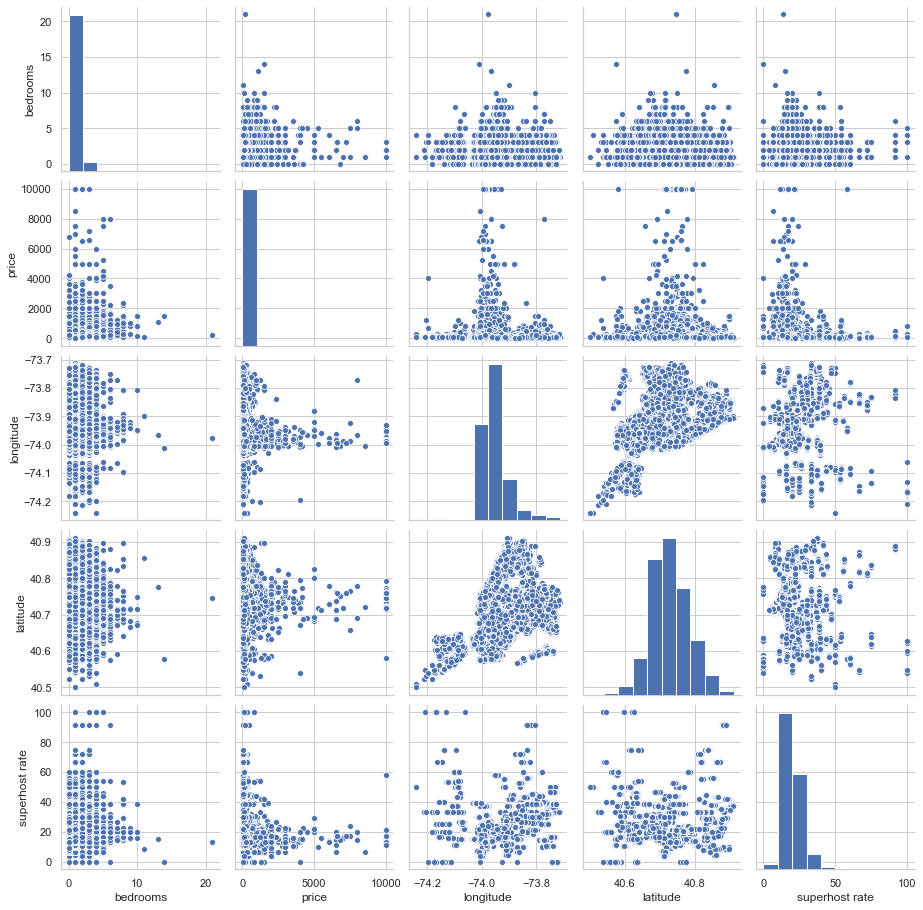

In [49]:
#see correlations between superhosts and price

sns.pairplot(pro_host_rate)

### Property Distribution

In [50]:
mapbox_access_token = 'pk.eyJ1IjoiZmlzdHoyNCIsImEiOiJja2J4YWxsZWkwZzl4MnBsamlhZzYzZG9lIn0.WcjiR65gcN4GubMtTjUwmw.mapbox_token'

px.set_mapbox_access_token(mapbox_access_token)

In [51]:
fig5 = px.scatter_mapbox(pro_host_rate,lat="latitude",lon="longitude",color="property_type",zoom=3,mapbox_style='open-street-map')
fig5.show()

In [52]:
#property distribution by superhost rate
fig6 = px.scatter_mapbox(up_30,lat="latitude",lon="longitude",color="superhost rate",zoom=3,mapbox_style='open-street-map', color_continuous_scale="BuPu")
fig6.show()